# Iterative Linear Quadratic Regulator
### Inverse pendulum on a cart

In [712]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import control
from scipy.integrate import odeint

# pydrake imports
from pydrake.all import (Variable, SymbolicVectorSystem, DiagramBuilder,
                         LogVectorOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, SnoptSolver, PiecewisePolynomial)
import pydrake.symbolic as sym
from scipy.integrate import solve_ivp

## Iterative Linear Quadratic Regulator Derivation

In this exercise we will derive the iterative Linear Quadratic Regulator (iLQR) solving the following optimization problem.

$\begin{aligned} \min_{\mathbf{u}[\cdot]} \quad & \ell_f(\mathbf{x}[N]) + \sum_{n=0}^{N-1} \ell(\mathbf{x}[n],\mathbf{u}[n]) \\ \text{subject to} \quad & \mathbf{x}[n+1] = (\mathbf{x}[n], \mathbf{u}[n]), \quad \forall n\in[0, N-1] \\ & \mathbf{x}[0] = \mathbf{x}_0\end{aligned}$

After completing this exercise you will be able to write your own MPC solver from scratch without any proprietary or third-party software (with the exception of auto-differentiation). You will derive all necessary equations yourself.
While the iLQR algorithm will be capable of solving general model predictive control problems in the form described above, we will apply it to the control of a vehicle. 

### Pendulum on cart control problem
Before we start the actual derivation of iLQR we will take a look at the pendulum on cart dynamics and cost functions.

Using the same convention as the book, we describe the state of the cart-pole as the vector $\mathbf{x} = [x, \dot{x}, \theta, \dot{\theta}]^\top$, and we let the force on the cart be the control input $\mathbf{u} = [f_x]$.

Use [equations (16) and (17)](https://underactuated.csail.mit.edu/acrobot.html#cart_pole) from the textbook for the accelerations:

$$\ddot{x} = \frac{1}{m_c + m_p \sin^2\theta}[ f_x+m_p \sin\theta (l \dot\theta^2 + g\cos\theta)]$$

$$\ddot{\theta} = \frac{1}{l(m_c + m_p \sin^2\theta)}[ -f_x \cos\theta - m_p l \dot\theta^2 \cos\theta \sin\theta - (m_c + m_p) g \sin\theta]$$

Complete the state-space model of the cart-pole by implementing the vector $\dot{\mathbf{x}} = [\dot{x}, \ddot{x}, \dot{\theta}, \ddot{\theta}]^\top$ as $\dot{\mathbf{x}} = {\bf f}(\mathbf{x}, \mathbf{u})$. Implement the function ${\bf f}$ below to return $\dot{\mathbf{x}}$.

In [713]:
# Compute trajectory
dt = 0.01
T = 5
num_time_pts = int(T / dt)
t = np.linspace(0, T, num_time_pts)

x_goal = np.array([0.0, 0.0, np.pi, 0.0])

In [714]:
n_x = 4
n_u = 1

m_p = 0.3 #1.0     # pendulum (bob) mass [kg]
m_c = 1.0     # cart mass [kg]
g = 9.81      # gravity [m/s^2]
l = 1.0       # length of a rod [m]
d = 0

In [715]:
# function that returns the A_lin matrix
def get_A_lin():
    A = np.array([
        [0, 1, 0, 0], 
        [0, -d/m_c, m_p*g/m_c, 0], 
        [0, 0, 0, 1], 
        [0, -d/(m_c*l), -(m_c+m_p)*g/(m_c*l), 0]  
    ])
    return A

# function that returns the B_lin matrix
def get_B_lin():
    B = np.array([
        [0], 
        [1/m_c], 
        [0], 
        [1/(m_c*l)]
    ])
    return B

In [742]:
# Design LQR controller
Qw = np.array([[500, 0, 0, 0],[0, 1, 0, 0],[0, 0, 500, 0], [0, 0, 0, 1]])
Rw = 1
A = get_A_lin()
B = get_B_lin()
L, S, E = control.lqr(A, B, Qw, Rw)

In [717]:
def pendcart(x, t):
    # x = [x_c, v_c, theta_p, omega_p] 
    # u = control input
    theta = x[2] 
    s = np.sin(theta)
    c = np.cos(theta)

    theta_dot = x[-1]
    x_dot = x[1]
    
    u = np.dot(-L, (x - x_goal))

    theta_dot_2 = ( (m_p+m_c)*g*s-m_p*l*(theta_dot**2)*s*c-u[0]*c +d*c*x_dot )/( l*(m_c+m_p*(s**2)) )
    x_dot_2 = (u[0]-m_p*g*s*c+m_p*l*(theta_dot**2)*s-d*x_dot)/(m_c+m_p*(s**2)) 
    
    x_d = np.array([
        x_dot,
        x_dot_2,
        theta_dot,
        theta_dot_2 
    ])
    return x_d

In [718]:
def pendulum_on_cart_continuous_dynamics(x, u):
    # x = [x_c, v_c, theta_p, omega_p] 
    # u = control input
    m = sym if x.dtype == object else np # Check type for autodiff
    theta = x[2] 
    s = m.sin(theta)
    c = m.cos(theta)

    theta_dot = x[-1]
    x_dot = x[1]

    theta_dot_2 = ( (m_p+m_c)*g*s-m_p*l*(theta_dot**2)*s*c-u[0]*c +d*c*x_dot )/( l*(m_c+m_p*(s**2)) )
    x_dot_2 = (u[0]-m_p*g*s*c+m_p*l*(theta_dot**2)*s-d*x_dot)/(m_c+m_p*(s**2)) 
    
    x_d = np.array([
        x_dot,
        x_dot_2,
        theta_dot,
        theta_dot_2 
    ])
    return x_d

In [719]:
# n_x = 4
# n_u = 1
# m_p = 0.3 #1.0     # pendulum (bob) mass [kg]
# m_c = 1.0     # cart mass [kg]
# g = 9.81      # gravity [m/s^2]
# l = 1.0       # length of a rod [m]

# def pendulum_on_cart_continuous_dynamics(x, u):
#     # x = [x_c, v_c, theta_p, omega_p] 
#     # u = control input
#     m = sym if x.dtype == object else np # Check type for autodiff
#     theta = x[2]
#     s = m.sin(theta)
#     c = m.cos(theta)

#     theta_dot = x[-1]
#     theta_dot_2 = -(1/( l*(m_c+m_p*(s**2)) ))*( (m_p+m_c)*g*s+m_p*l*(theta_dot**2)*s*c+u[0]*c )
#     x_dot = x[1]
#     x_dot_2 = (u[0]+m_p*g*s*c+m_p*l*(theta_dot**2)*s)/(m_c+m_p*(s**2)) 
#     x_d = np.array([
#         x_dot,
#         x_dot_2,
#         theta_dot,
#         theta_dot_2 
#     ])
#     return x_d

In [720]:
def rk4singlestep(x0, u0):
    """
        This function does a single 4th-order Runge-Kutta
    """

    f1 = pendulum_on_cart_continuous_dynamics(x0, u0)
    f2 = pendulum_on_cart_continuous_dynamics(x0 + (dt/2) * f1, u0)
    f3 = pendulum_on_cart_continuous_dynamics(x0 + (dt/2) * f2, u0)
    f4 = pendulum_on_cart_continuous_dynamics(x0 + dt * f3, u0)
    x_next = x0 + (dt/6) * (f1 + 2 * f2 + 2 * f3 + f4)

    return x_next

def euler_single_step(fun, dt, t0, x0):

    x_next = x0 + dt * fun(t0, x0)

    return x_next 

### Euler integrator (Recap)
Euler method, also known as forward Euler method, is a 1-st order numerical procedure for solving ODEs with a given initial value. Euler method is the most basic explicit method for numerical integration of ODEs and is known as the simplest version of Runge-Kutta method.

<br>

Since Euler method is a 1-st order method, it means also that the local and global error (per step) is proportional to the square of the step size.

<br>



In [721]:
# def discrete_dynamics(x, u):
#     x_next = x + dt * pendulum_on_cart_continuous_dynamics(x, u)
#     return x_next

Given an initial state $\mathbf{x}_0$ and a guess of a control trajectory $\mathbf{u}[0:N-1]$ we roll out the state trajectory $x[0:N]$ until the time horizon $N$. Please complete the rollout function.

In [722]:
def rollout(x0, u_trj):
    x_trj = np.zeros((u_trj.shape[0]+1, x0.shape[0]))
    # Define the rollout here and return the state trajectory x_trj: [N, number of states]
    N = u_trj.shape[0]+1
    x_trj[0] = x0 
    for n in range(N-1):
        # x_trj[n+1] = rk4singlestep(pendulum_on_cart_continuous_dynamics, dt, t[n], x_trj[n], u_trj[n])
        x_trj[n+1] = rk4singlestep(x_trj[n], u_trj[n])
        
    return x_trj

# Debug your implementation with this example code
# N = 10
# x0 = np.array([0, 0, np.pi, 0])
# u_trj = np.zeros((N-1, n_u))
# x_trj = rollout(x0, u_trj)

We define the stage cost function $\ell$ and final cost function $\ell_f$. The goal of these cost functions is to drive the vehicle along a circle with radius $r$ around the origin with a desired speed.

In [723]:
def cost_stage(x, u):
    m = sym if x.dtype == object else np # Check type for autodiff
    n_x = x.shape[0]
    Q = np.array([[500, 0, 0, 0],[0, 1, 0, 0],[0, 0, 500, 0], [0, 0, 0, 1]])
    R = 1
    return (x-x_goal).T@Q@(x-x_goal) + R*(u**2)[0] 

def cost_final(x):
    m = sym if x.dtype == object else np # Check type for autodiff
    n_x = x.shape[0]
    Q = np.array([[500, 0, 0, 0],[0, 1, 0, 0],[0, 0, 500, 0], [0, 0, 0, 1]])
    return (x-x_goal).T@Q@(x-x_goal)

Your next task is to write the total cost function of the state and control trajectory. This is simply the sum of all stages over the control horizon and the objective from general problem formulation above.

In [724]:
def cost_trj(x_trj, u_trj):
    total = 0.0
    # Sum up all costs
    N = u_trj.shape[0]+1
    for n in range(N-1):
        total += cost_stage(x_trj[n], u_trj[n]) 
    
    total += cost_final(x_trj[-1])

    return total
    
# # Debug your code
# cost_trj(x_trj, u_trj)

### Bellman Recursion

Now that we are warmed up, let's derive the actual algorithm. We start with the Bellman equation known from lecture defining optimality in a recursively backwards in time.

$$\begin{aligned} V(\mathbf{x}[n]) = & \min_{\mathbf{u}[n]} \quad \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\ \end{aligned}$$

You may have noticed that we neglected a couple of constraints of the original problem formulation. The fully equivalent formulation is 

$$\begin{aligned} \min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]), \quad \forall n\in[0, N-1] \\ \text{subject to} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]) = \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\ & V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N]) \\ & \mathbf{x}[n+1] = {\bf      f}(\mathbf{x}[n], \mathbf{u}[n]), \quad \\ & \mathbf{x}[0] = \mathbf{x}_0 \end{aligned}$$

The definition of a Q-function will become handy during the derivation of the algorithm.

The key idea of iLQR is simple: Approximate the dynamics linearly and the costs quadratically around a nominal trajectory. We will expand all terms of the Q-function accordingly and optimize the resulting quadratic equation for an optimal linear control law in closed form. We will see that by applying the Bellman equation recursively backwards in time, the value function remains a quadratic.
The linear and quadratic approximations are computed around the nominal state $\bf \bar{x} = \bf x - \delta \bf x$ and the nominal control $\bf \bar{u} = \bf u - \delta \bf u$. After applying the Bellman equation backwards in time from time $N$ to $0$ (the backward pass), we will update the nominal controls $\bf \bar{u}$ and states $\bf \bar{x}$ by applying the computed linear feedback law from the backward pass and rolling out the dynamics from the initial state $\bf x_0$ to the final horizon $N$. Iterating between backwards and forwards pass optimizes the control problem.

### Q-function Expansion

Let's start by expanding all terms in the Q-function of the Bellman equation. The quadaratic cost function is

$$\begin{aligned} \ell(\mathbf{x}[n], \mathbf{u}[n]) \approx \ell_n + \begin{bmatrix}\ell_{\mathbf{x},n} \\  \ell_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T \begin{bmatrix}\ell_{\mathbf{xx},n} &  \ell_{\mathbf{ux},n}^T\\ \ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n}\end{bmatrix} \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix},\end{aligned}$$

and the dynamics function is

$$\begin{aligned} x[n+1]= \mathbf{f}(\mathbf{x}[n], \mathbf{u}[n]) \approx \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}. \end{aligned}$$

Here, $\ell = \ell(\bar{\mathbf{x}}, \bar{\mathbf{u}})$ and $\mathbf{f} = \mathbf{f}(\bar{\mathbf{x}}, \bar{\mathbf{u}})$. $\ell_\mathbf{x}, \ell_\mathbf{u}, \mathbf{f}_\mathbf{x}, \mathbf{f}_\mathbf{u}$ are the gradients and Jacobians evaluated at $\bar{\mathbf{x}}$ and $\bar{\mathbf{u}}$. $\ell_\mathbf{xx}, \ell_\mathbf{ux}, \ell_\mathbf{uu}$ are the Hessians at $\bar{\mathbf{x}}$ and $\bar{\mathbf{u}}$. The expansion of the final cost follows analogously.
The code to evaluate all the derivative terms is:

In [725]:
class derivatives():
    def __init__(self, discrete_dynamics, cost_stage, cost_final, n_x, n_u):
        self.x_sym = np.array([sym.Variable("x_{}".format(i)) for i in range(n_x)])
        self.u_sym = np.array([sym.Variable("u_{}".format(i)) for i in range(n_u)])
        # self.t_sym = np.array([sym.Variable("t_{}".format(i)) for i in range(N)])
        x = self.x_sym
        u = self.u_sym
        # t = self.t_sym 

        l = cost_stage(x, u)
        self.l_x = sym.Jacobian([l], x).ravel()
        self.l_u = sym.Jacobian([l], u).ravel()
        self.l_xx = sym.Jacobian(self.l_x, x)
        self.l_ux = sym.Jacobian(self.l_u, x)
        self.l_uu = sym.Jacobian(self.l_u, u)
        
        l_final = cost_final(x)
        self.l_final_x = sym.Jacobian([l_final], x).ravel()
        self.l_final_xx = sym.Jacobian(self.l_final_x, x)
        
        f = discrete_dynamics(x, u)
        self.f_x = sym.Jacobian(f, x)
        self.f_u = sym.Jacobian(f, u)
    
    def stage(self, x, u):
        env = {self.x_sym[i]: x[i] for i in range(x.shape[0])}
        env.update({self.u_sym[i]: u[i] for i in range(u.shape[0])})
        
        l_x = sym.Evaluate(self.l_x, env).ravel()
        l_u = sym.Evaluate(self.l_u, env).ravel()
        l_xx = sym.Evaluate(self.l_xx, env)
        l_ux = sym.Evaluate(self.l_ux, env)
        l_uu = sym.Evaluate(self.l_uu, env)
        
        f_x = sym.Evaluate(self.f_x, env)
        f_u = sym.Evaluate(self.f_u, env)

        return l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u
    
    def final(self, x):
        env = {self.x_sym[i]: x[i] for i in range(x.shape[0])}
        
        l_final_x = sym.Evaluate(self.l_final_x, env).ravel()
        l_final_xx = sym.Evaluate(self.l_final_xx, env)
        
        return l_final_x, l_final_xx
        
# derivs = derivatives(discrete_dynamics, cost_stage, cost_final, n_x, n_u)
derivs = derivatives(rk4singlestep, cost_stage, cost_final, n_x, n_u)

# Test the output:
# x = np.array([0, 0, 0, 0, 0])
# u = np.array([0, 0])
# print(derivs.stage(x, u))
# print(derivs.final(x))

## Dynamics Linearized Around the Unstable Equilibrium
We will now approximate the nonlinear dynamics with a linear one.
This will allow us to use basic linear control to locally stabilize the cart-pole with the pole in the vertical configuration.

We consider the unstable equilibrium state $$\mathbf{x}^* = [x, v, \theta, \omega]^\top = [0, 0, \pi, 0]^\top,$$ with the related equilibrium control input $$\mathbf{u}^* = [0].$$
As in [the text](https://underactuated.csail.mit.edu/acrobot.html#linearizing_manip), we want to derive a linear model in the from
$$\dot{\bar{\mathbf{x}}} = A_{\text{lin}} \mathbf{\bar{x}} + B_{\text{lin}} \mathbf{\bar{u}},$$
where $\mathbf{\bar{x}} = \mathbf{x}-\mathbf{x}^*$ and $\mathbf{\bar{u}} = \mathbf{u} -\mathbf{u}^*$.

Follow the recipe described in [the textbook](https://underactuated.csail.mit.edu/acrobot.html#linearizing_manip) to derive the linearization matrices $A_{\text{lin}}$ and $B_{\text{lin}}$, and implement them in the cell below. You will need to do some simple matrix math to derive the components. This [example in the text](https://underactuated.csail.mit.edu/acrobot.html#linearize_cart_pole) may be a helpful reference for this derivation.

Hint: Many of our parameters are constants set to 1, which simplifies the terms in the manipulator equations substantially.

In [726]:
# # function that returns the A_lin matrix
# def get_A_lin():
#     A = np.array([
#         [0, 1, 0, 0], 
#         [0, -d/m_c, m_p*g/m_c, 0], 
#         [0, 0, 0, 1], 
#         [0, -d/(m_c*l), -(m_c+m_p)*g/(m_c*l), 0]  
#     ])
#     return A

# # function that returns the B_lin matrix
# def get_B_lin():
#     B = np.array([
#         [0], 
#         [1/m_c], 
#         [0], 
#         [1/(m_c*l)]
#     ])
#     return B

Expanding the second term of the Q-function of the Bellman equation, i.e. the value function at the next state $\mathbf{x}[n+1]$, to second order yields 

$$\begin{aligned} V(\mathbf{x}[n+1]) \approx V_{n+1} + V_{\mathbf{x},n+1}^\top  \delta \mathbf{x}[n+1] + \frac{1}{2}\delta \mathbf{x}[n+1]^\top V_{\mathbf{xx},n+1} \delta \mathbf{x}[n+1],\end{aligned}$$

where $\delta \mathbf{x}[n+1]$ is given by

$$\begin{aligned} \delta \mathbf{x}[n+1] & = \mathbf{x}[n+1] - \bar{\mathbf{x}}[n+1] \\ & = \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} &  \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} -  \bar{\mathbf{x}}[n+1] \\ & = \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} -  \mathbf{f}(\bar{\mathbf{x}}[n], \bar{\mathbf{u}}[n]) \\ & = \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} &  \mathbf{f}_{\mathbf{u},n} \end{bmatrix}   \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}. \end{aligned}$$

We have now expanded all terms of the Bellman equation and can regroup them in the form of

$$\begin{aligned} Q(\mathbf{x}[n], \mathbf{u}[n]) & \approx \ell_n + \begin{bmatrix}\ell_{\mathbf{x},n} \\  \ell_{\mathbf{u},n} \end{bmatrix} ^\top  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^\top \begin{bmatrix}\ell_{\mathbf{xx},n} &  \ell_{\mathbf{ux},n}^\top\\  \ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n}\end{bmatrix} \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}, \\ & \quad + V_{n+1} + V_{\mathbf{x},n+1}^\top  \delta \mathbf{x}[n+1] + \frac{1}{2}\delta \mathbf{x}[n+1]^\top V_{\mathbf{xx},n+1} \delta \mathbf{x}[n+1], \\& = Q_n + \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix} ^\top  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^\top \begin{bmatrix} Q_{\mathbf{xx},n} & Q_{\mathbf{ux},n}^T\\  Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix} \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}.\end{aligned}$$

Find $Q_{\mathbf{x},n}$, $Q_{\mathbf{u},n}$, $Q_{\mathbf{xx},n}$, $Q_{\mathbf{ux},n}$, $Q_{\mathbf{uu},n}$ in terms of $\ell$ and $\textbf{f}$ and their expansions by collecitng coefficients in $(\cdot)\delta \mathbf{x}[n]$, $(\cdot)\delta \mathbf{u}[n]$, $1/2 \delta \mathbf{x}[n]^\top (\cdot) \delta \mathbf{x}[n]$, and similar. Write your results in the corresponding function below.

Answer:
<br>
$$Q_{\mathbf{x},n} = \ell_{\mathbf{x},n} + \mathbf{f}_{\mathbf{x},n}^\top V_{\mathbf{x},n+1} 
\\ \\
Q_{\mathbf{u},n} = \ell_{\mathbf{u},n} + \mathbf{f}_{\mathbf{u},n}^\top V_{\mathbf{x},n+1} 
\\ \\ 
Q_{\mathbf{xx},n} = \ell_{\mathbf{xx},n} + \mathbf{f}_{\mathbf{x},n}^\top V_{\mathbf{xx},n+1} \mathbf{f}_{\mathbf{x},n} 
\\ \\ 
Q_{\mathbf{uu},n} = \ell_{\mathbf{uu},n} + \mathbf{f}_{\mathbf{u},n}^\top V_{\mathbf{xx},n+1} \mathbf{f}_{\mathbf{u},n} 
\\ \\
Q_{\mathbf{ux},n} = \ell_{\mathbf{ux},n} + \mathbf{f}_{\mathbf{u},n}^\top V_{\mathbf{xx},n+1} \mathbf{f}_{\mathbf{x},n} 
\\ \\
Q_{\mathbf{ux},n} = Q_{\mathbf{xu},n}^\top

$$

In [727]:
def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
    # Define the Q-terms here
    Q_x = l_x + f_x.T@V_x 
    Q_u = l_u + f_u.T@V_x 
    Q_xx = l_xx + f_x.T@V_xx@f_x 
    Q_uu = l_uu + f_u.T@V_xx@f_u 
    Q_ux = l_ux + f_u.T@V_xx@f_x 
    
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

In [728]:
def Q_fun(F, C, c, V_xx, V_x, x, u):
    # Define the Q-terms here
    Q = C + F.T@V_xx@F
    q = c + F.T@V_x
    
    q_x = q[0:n_x]
    q_u = q[n_x:]

    Q_xx = Q[0:n_x,0:n_x]
    Q_ux = Q[n_x:, 0:n_x]
    Q_uu = Q[n_x:, n_x:]
    
    return Q_xx, Q_ux, Q_uu, q_x, q_u

### Q-function Optimization and Optimal Linear Control Law
Amazing! Now that we have the Q-function in quadratic form, we can optimize for the optimal control gains in closed form.
The original formulation, i.e. optimizing over $\mathbf{u}[n]$, $$\begin{aligned} \min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]),\end{aligned}$$ is equivalent to optimzing over $\delta \mathbf{u}[n]$.

$$\begin{aligned} \delta \mathbf{u}[n]^* = {\arg\!\min}_{\delta \mathbf{u}[n]} \quad Q_n  + \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T \begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} = k + K \delta \mathbf{x}[n]\end{aligned}$$

It turns out that the optimal control is linear in $\delta \mathbf{x}[n]$.
Solve the quadratic optimization analytically and derive equations for the feedforward gains $k$ and feedback gains $K$. Implement the function below. Hint: You do not need to compute $Q_\mathbf{uu}^{-1}$ by hand.

The feedforward gains $k$ and $K$ equal:
<br>
$K=-Q_{\mathbf{uu},n}^{-1}Q_{\mathbf{ux},n}$; 
<br>
$k=-Q_{\mathbf{uu},n}^{-1}Q_{\mathbf{u},n}$

In [729]:
def gains(Q_uu, Q_u, Q_ux):
    Q_uu_inv = np.linalg.inv(Q_uu)
    # Implement the feedforward gain k and feedback gain K.
    k = -Q_uu_inv@Q_u
    K = -Q_uu_inv@Q_ux
    
    return k, K

### Value Function Backward Update
We are almost done! We need to derive the backwards update equation for the value function. We simply plugin the optimal control $\delta \mathbf{u}[n]^* = k + K \delta \mathbf{x}[n]$ back into the Q-function which yields the value function

$$\begin{aligned} V(\mathbf{x}[n]) \approx V_{n} + V_{\mathbf{x},n}^T  \delta \mathbf{x}[n] + \frac{1}{2}\delta \mathbf{x}[n]^T V_{\mathbf{xx},n} \delta \mathbf{x}[n] = Q_n + \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix}^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix}^T \begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix} \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix}. \end{aligned}$$

Compare terms in $(\cdot) \delta \mathbf{x}[n]$ and $ 1/2 \delta \mathbf{x}[n]^T (\cdot)  \delta \mathbf{x}[n]$, find $V_{\mathbf{x},n}$, and $V_{\mathbf{xx},n}$ and implement the corresponding function below.

IMPORTANT: Do not simplify the expression you obtain for $V_{x}$ and $V_{xx}$ by assuming that $k$ and $K$ have the form computed by the function `gains`.

The expression of $V_{\mathbf{x},n}$ and $V_{\mathbf{xx},n}$ are:
<br>
<br>
$V_{\mathbf{x},n} = Q_{\mathbf{x},n} + K^\top Q_{\mathbf{u},n} + Q_{\mathbf{ux},n}^\top k + k^\top Q_{\mathbf{uu},n}$
<br>
$V_{\mathbf{xx},n} = Q_{\mathbf{xx},n} + Q_{\mathbf{ux},n}^\top K + K^\top Q_{\mathbf{ux},n}  + K^\top Q_{\mathbf{uu},n} K$

In [730]:
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    # Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.

    V_x = Q_x + K.T@Q_u + Q_ux.T@k + k.T@Q_uu@K 
    V_xx = Q_xx + Q_ux.T@K + K.T@Q_ux + K.T@Q_uu@K 
    
    return V_x, V_xx

### Expected Cost Reduction
We can also estimate by how much we expect to reduce the cost by applying the optimal controls. Simply subtract the previous nominal Q-value ($\delta \mathbf{x}[n] = 0$ and $\delta \mathbf{u}[n]=0$) from the value function.  The result is implemented below and is a useful aid in checking how accurate the quadratic approximation is during convergence of iLQR and adapting stepsize and regularization.

In [731]:
def expected_cost_reduction(Q_u, Q_uu, k):
    return -Q_u.T.dot(k) - 0.5 * k.T.dot(Q_uu.dot(k))

## Linearization Error
The linear model we have built above is very accurate accurate in the vicinity of the equilibrium point, but can lead to very bad predictions if our state is far away from the equilibrium.

The following function, for a given state $\mathbf{x}$ and control $\mathbf{u}$, evaluates the linearization error:
$$e(\mathbf{x}, \mathbf{u}) = \| {\bf f}(\mathbf{x}, \mathbf{u}) - {\bf f_{\text{lin}}}(\mathbf{x}, \mathbf{u}) \|$$

### Forward Pass
We have now all the ingredients to implement the forward pass and the backward pass of iLQR. In the forward pass, at each timestep the new updated control $\mathbf{u}' =  \bar{\mathbf{u}} + k + K (x' - \bar{\mathbf{x}})$ is applied and the dynamis propagated based on the updated control. The nominal control and state trajectory $\bar{\mathbf{u}}, \bar{\mathbf{x}}$ with which we computed $k$ and $K$ are then updated and we receive a new set of state and control trajectories.

#### Standard LQR
for $t = 1:T$
<br>
&nbsp; &nbsp; $\mathbf{u}_t = \mathbf{K}_t\mathbf{x}_t+\mathbf{k}_t$
<br>
&nbsp; &nbsp; $\mathbf{x}_{t+1} = f(\mathbf{x}_t,\mathbf{u}_t)$

In [732]:
def forward_pass_lqr(x_trj, u_trj):
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0,:] = x_trj[0,:]
    u_trj_new = np.zeros(u_trj.shape)

    # Implement the forward pass here
    for n in range(u_trj.shape[0]):
        u_trj_new[n,:] = np.dot(-K, (x_trj_new[n]-x_goal))[0] #-K.dot(x_trj_new[n]-x_goal)# Apply feedback law
        x_trj_new[n+1,:] = rk4singlestep(x_trj_new[n], u_trj_new[n])
    return x_trj_new, u_trj_new

In [733]:
# def forward_pass_lqr(x_trj, u_trj, k_trj, K_trj):
#     x_trj_new = np.zeros(x_trj.shape)
#     x_trj_new[0,:] = x_trj[0,:]
#     u_trj_new = np.zeros(u_trj.shape)

#     # Implement the forward pass here
#     for n in range(u_trj.shape[0]):
#         u_trj_new[n,:] = k_trj[n] + K_trj[n].dot(x_trj_new[n]-x_goal)# Apply feedback law
#         x_trj_new[n+1,:] = rk4singlestep(x_trj_new[n], u_trj_new[n])
#     return x_trj_new, u_trj_new

#### iLQR
for $t = 1:T$
<br>
&nbsp; &nbsp; $\mathbf{u}_t = \hat{\mathbf{u}}_t + \mathbf{k}_t + \mathbf{K}_t(\mathbf{x}_t-\hat{\mathbf{x}}_t)$
<br>
&nbsp; &nbsp; $\mathbf{x}_{t+1} = f(\mathbf{x}_t,\mathbf{u}_t)$

In [734]:
def forward_pass(x_trj, u_trj, k_trj, K_trj):
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0,:] = x_trj[0,:]
    u_trj_new = np.zeros(u_trj.shape)

    # Implement the forward pass here
    for n in range(u_trj.shape[0]):
        u_trj_new[n,:] = u_trj[n] + k_trj[n] + K_trj[n].dot(x_trj_new[n]-x_trj[n])# Apply feedback law
        # u_trj_new[n,:] = u_trj[n] + k_trj[n] + K_trj[n].dot(x_trj_new[n]-x_goal)# Apply feedback law
        # x_trj_new[n+1,:] = discrete_dynamics(x_trj_new[n], u_trj_new[n])# Apply dynamics
        x_trj_new[n+1,:] = rk4singlestep(x_trj_new[n], u_trj_new[n])
    return x_trj_new, u_trj_new

### Backward Pass
The backward pass starts from the terminal boundary condition $V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N])$, such that $V_{\mathbf{x},N} = \ell_{\mathbf{x},f}$ and $V_{\mathbf{xx},N} = \ell_{\mathbf{xx},f}$. In the backwards loop terms for the Q-function at $n$ are computed based on the quadratic value function approximation at $n+1$ and the derivatives and hessians of dynamics and cost functions at $n$. To solve for the gains $k$ and $K$ an inversion of the matrix $Q_\mathbf{uu}$ is necessary. To ensure invertability and to improve conditioning we add a diagonal matrix to $Q_\mathbf{uu}$. This is equivalent to adding a quadratic penalty on the distance of the new control trajectory from the control trajectory of the previous iteration. The result is a smaller stepsize and more conservative convergence properties.

In [735]:
def backward_pass_lqr(x_trj, u_trj, regu):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0
    # Set terminal boundary condition here (V_x, V_xx)
    V_xx = np.zeros((n_x, n_x))
    V_x = np.zeros((n_x))

    Cxx = np.array([[50, 0, 0, 0],[0, 1, 0, 0],[0, 0, 50, 0], [0, 0, 0, 1]])
    Cuu = np.array([[1]])
    C = np.vstack((np.hstack((Cxx, np.zeros([n_x, 1]))), np.hstack((np.zeros([1, n_x]), Cuu))))
    c = np.vstack([np.zeros([n_x,1]), np.zeros([n_u,1])]).reshape(-1)

    F = np.hstack((get_A_lin(), get_B_lin()))
    
    for n in range(u_trj.shape[0]-1, -1, -1):
        # First compute derivatives, then the Q-terms 
        
        Q_xx, Q_ux, Q_uu, q_x, q_u = Q_fun(F, C, c, V_xx, V_x, x_trj[n], u_trj[n])
        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        # i.e., we apply regularization term to the local cost to account for the non-positive-definite second order 
        # Hessian's computed on the cost:
        Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
        k, K = gains(Q_uu_regu, q_u, Q_ux)
        k_trj[n,:] = k
        K_trj[n,:,:] = K
        V_x, V_xx = V_terms(q_x, q_u, Q_xx, Q_ux, Q_uu, K, k)
        expected_cost_redu += expected_cost_reduction(q_u, Q_uu, k)
        
    return k_trj, K_trj, expected_cost_redu

In [736]:
def backward_pass(x_trj, u_trj, regu):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0
    # Set terminal boundary condition here (V_x, V_xx)
    V_x, V_xx = derivs.final(x_trj[-1])

    for n in range(u_trj.shape[0]-1, -1, -1):
        # First compute derivatives, then the Q-terms 
        l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = derivs.stage(x_trj[n], u_trj[n])
        Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        # i.e., we apply regularization term to the local cost to account for the non-positive-definite second order 
        # Hessian's computed on the cost:
        Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
        k, K = gains(Q_uu_regu, Q_u, Q_ux)
        k_trj[n,:] = k
        K_trj[n,:,:] = K
        V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
        expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k)
    return k_trj, K_trj, expected_cost_redu

In [737]:
# def backward_pass(x_trj, u_trj, regu):
#     k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
#     K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
#     expected_cost_redu = 0
#     # Set terminal boundary condition here (V_x, V_xx)
#     V_xx = np.zeros((n_x, n_x))
#     V_x = np.zeros((n_x))

#     for n in range(u_trj.shape[0]-1, -1, -1):
#         # First compute derivatives, then the Q-terms 
#         l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = derivs.stage(x_trj[n], u_trj[n])
#         if n == u_trj.shape[0]-1:
#             l_x, l_xx = derivs.final(x_trj[-1])
        
#         F = np.hstack((f_x, f_u))
#         c = np.vstack((l_x.reshape(n_x,1), l_u.reshape(n_u,1))).reshape(-1)
#         C = np.vstack((np.hstack((l_xx, l_ux.T)), np.hstack((l_ux, l_uu))))
#         # Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
#         Q_xx, Q_ux, Q_uu, q_x, q_u = Q_fun(F, C, c, V_xx, V_x, x_trj[n], u_trj[n])
#         # We add regularization to ensure that Q_uu is invertible and nicely conditioned
#         # i.e., we apply regularization term to the local cost to account for the non-positive-definite second order 
#         # Hessian's computed on the cost:
#         Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
#         k, K = gains(Q_uu_regu, q_u, Q_ux)
#         k_trj[n,:] = k
#         K_trj[n,:,:] = K
#         V_x, V_xx = V_terms(q_x, q_u, Q_xx, Q_ux, Q_uu, K, k)
#         expected_cost_redu += expected_cost_reduction(q_u, Q_uu, k)
        
#     return k_trj, K_trj, expected_cost_redu

### Main Loop

The main iLQR loop consists of iteratively applying the forward and backward pass. The regularization is adapted based on whether the new control and state trajectories improved the cost. We lower the regularization if the total cost was reduced and accept the new trajectory pair. If the total cost did not decrease, the trajectory pair is rejected and the regularization is increased. You may want to test the algorithm with deactivated regularization and observe the changed behavior.
The main loop stops if the maximum number of iterations is reached or the expected reduction is below a certain threshold.

If you have correctly implemented all subparts of the iLQR you should see that the car plans to drive around the circle.

iLQR timer: 8.631940603256226
LQR timer: 0.0219879150390625


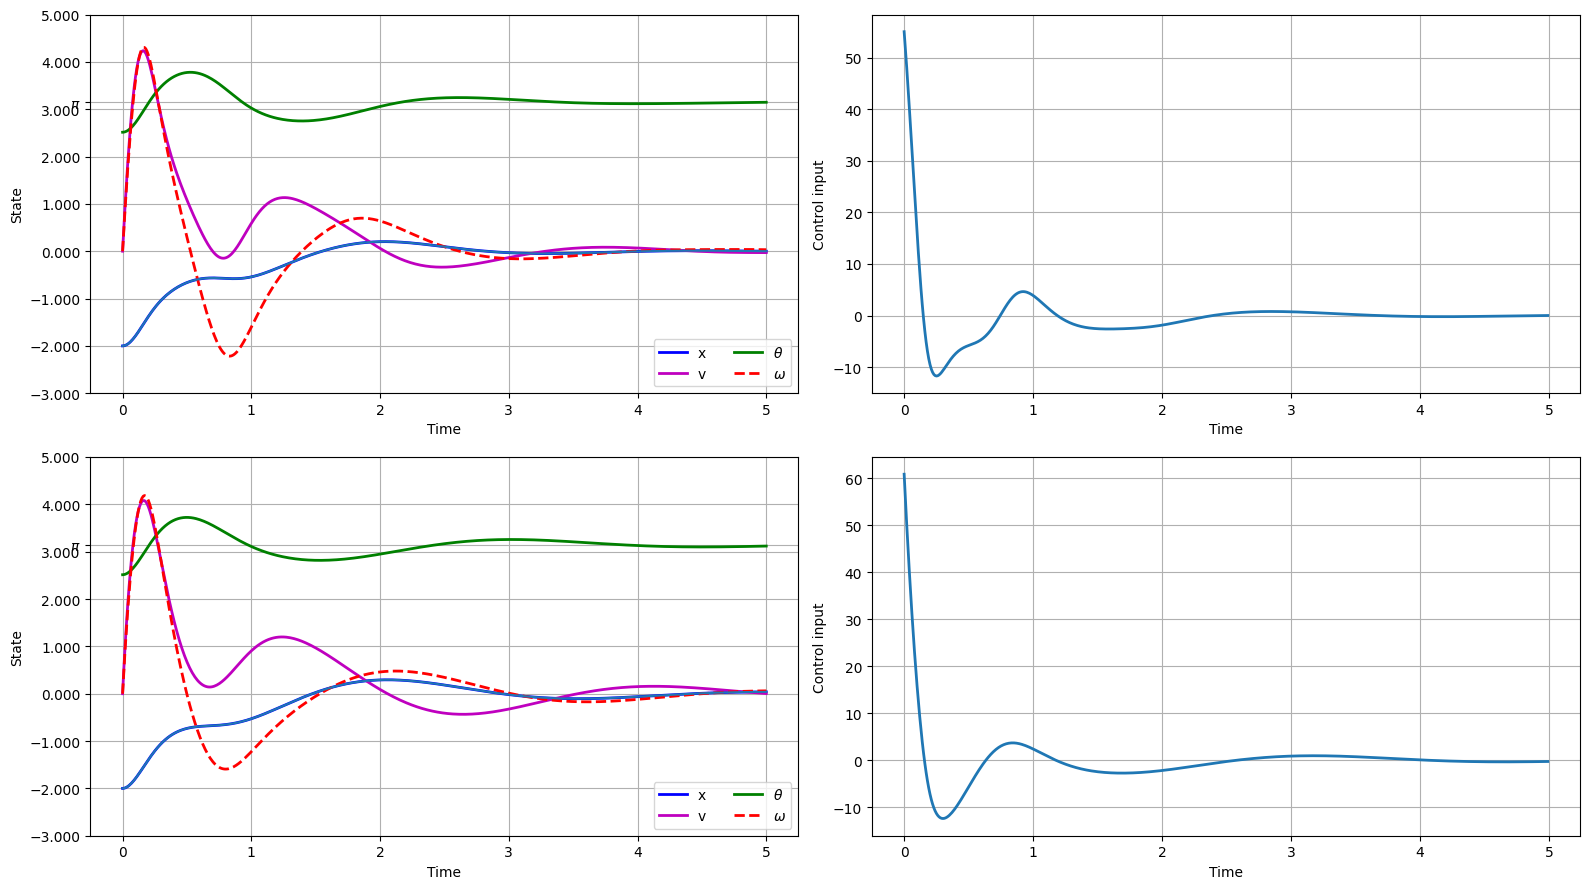

In [738]:
def run_ilqr(x0, N, max_iter=50, regu_init=100, alg='ilqr'):
    # First forward rollout
    u_trj = np.random.randn(N-1, n_u)*0.0001
    x_trj = rollout(x0, u_trj)
    total_cost = cost_trj(x_trj, u_trj)
    regu = regu_init
    max_regu = 10000
    min_regu = 0.01
    
    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]
    
    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        if alg == 'ilqr':
            k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu)
            x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj)
        else:
            # k_trj, K_trj, expected_cost_redu = backward_pass_lqr(x_trj, u_trj, regu)
            expected_cost_redu=10
            # x_trj_new, u_trj_new = forward_pass_lqr(x_trj, u_trj)
            x_trj_new = odeint(pendcart, x0, t)
            u_trj_new = np.zeros(u_trj.shape)
            for ii in range(N-1):
                u_trj_new[ii,:] = np.dot(-L, (x_trj_new[ii,:] - x_goal))[0]
            # x_trj_new, u_trj_new = forward_pass_lqr(x_trj, u_trj, k_trj, K_trj)

        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new)
        cost_redu = cost_trace[-1] - total_cost
        redu_ratio = cost_redu / abs(expected_cost_redu)
        # Accept or reject iteration
        if cost_redu > 0:
            # Improvement! Accept new trajectories and lower regularization
            redu_ratio_trace.append(redu_ratio)
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.7
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            cost_trace.append(cost_trace[-1])
            redu_ratio_trace.append(0)
        regu = min(max(regu, min_regu), max_regu)
        regu_trace.append(regu)
        redu_trace.append(cost_redu)

        # Early termination if expected improvement is small
        if expected_cost_redu <= 1e-6:
            break


    return x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace

# Setup problem and call iLQR
x0 = np.array([-2.0, 0.0, 0.8*np.pi, 0.0])


# Run iLQR
max_iter=50
regu_init=100
tt = time.time()
# do stuff
x_trj_ilqr, u_trj_ilqr, cost_trace, regu_trace, redu_ratio_trace, redu_trace = run_ilqr(x0, num_time_pts, max_iter, regu_init)
print("iLQR timer: " + str(time.time() - tt) )
# Run LQR
max_iter=1
regu_init=100
tt = time.time()
x_trj_lqr, u_trj_lqr, cost_trace_lqr, regu_trace_lqr, redu_ratio_trace_lqr, redu_trace_lqr = run_ilqr(x0, num_time_pts, max_iter, regu_init, alg='lqr')
print("LQR timer: " + str(time.time() - tt) )

lw_=2
plt.figure(figsize=(16,9))
ax1 = plt.subplot(221)
# ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.plot(t, x_trj_ilqr[:,0],lw=lw_,label = 'x', color = 'b')
ax1.plot(t, x_trj_ilqr[:,1],lw=lw_,linestyle = '-', color = 'm', label='v')
ax1.plot(t, x_trj_ilqr[:,2],lw=lw_, color='g', label=r'$\theta$')
ax1.plot(t, x_trj_ilqr[:,3],lw=lw_,linestyle = '--', color = 'r', label=r'$\omega$')
# ax1.axhline(y = np.pi, color = 'k', linestyle = '--', lw=2, label = r'$\pi$')
# Add ytick label of the theta target goal (pi)
lines = plt.plot(t, x_trj_ilqr[:,0])
ax0 = lines[0].axes
ax0.set_yticks(list(ax0.get_yticks())+[np.pi])
labels = [item.get_text() for item in ax0.get_yticklabels()]
labels[-1] = r'$\pi$'
ax0.set_yticklabels(labels)

ax1.set_xlabel('Time')
ax1.set_ylabel('State')
ax1.legend(ncols=2, loc='lower right', fontsize=15)
ax1.grid(True)

ax2 = plt.subplot(222)
# ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.plot(t[:-1], u_trj_ilqr,lw=lw_)
ax2.set_xlabel('Time')
ax2.set_ylabel('Control input')
ax2.grid(True)


# Plot LQR
ax3 = plt.subplot(223)
ax3.plot(t, x_trj_lqr[:,0],lw=lw_,label = 'x', color = 'b')
ax3.plot(t, x_trj_lqr[:,1],lw=lw_,linestyle = '-', color = 'm', label='v')
ax3.plot(t, x_trj_lqr[:,2],lw=lw_, color='g', label=r'$\theta$')
ax3.plot(t, x_trj_lqr[:,3],lw=lw_,linestyle = '--', color = 'r', label=r'$\omega$')
# ax1.axhline(y = np.pi, color = 'k', linestyle = '--', lw=2, label = r'$\pi$')
# Add ytick label of the theta target goal (pi)
lines = plt.plot(t, x_trj_lqr[:,0])
ax00 = lines[0].axes
ax00.set_yticks(list(ax00.get_yticks())+[np.pi])
labels = [item.get_text() for item in ax00.get_yticklabels()]
labels[-1] = r'$\pi$'
ax00.set_yticklabels(labels)

ax3.set_xlabel('Time')
ax3.set_ylabel('State')
ax3.legend(ncols=2, loc='lower right', fontsize=15)
ax3.grid(True)

ax4 = plt.subplot(224)
# ax2.margins(2, 2)           # Values >0.0 zoom out
ax4.plot(t[:-1], u_trj_lqr,lw=lw_)
ax4.set_xlabel('Time')
ax4.set_ylabel('Control input')
ax4.grid(True)

plt.tight_layout() 

Text(0.5, 1.0, 'Phase Portrait')

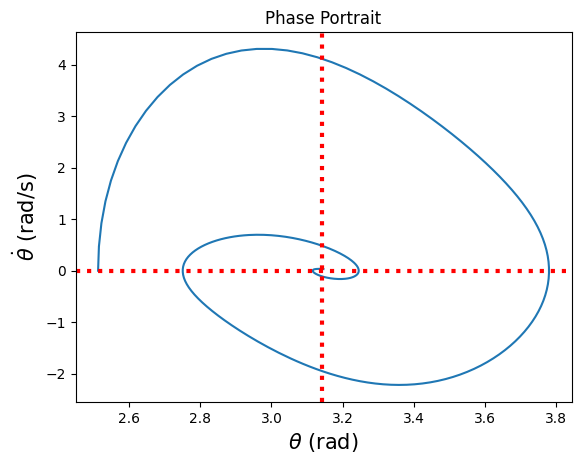

In [739]:
plt.plot(x_trj_ilqr[:,2], x_trj_ilqr[:,3])
plt.axvline(x = np.pi, color = 'r', lw=3, linestyle=':')
plt.axhline(y = 0, color = 'r', lw=3, linestyle=':')
plt.xlabel(r"$\theta$ (rad)", fontsize=15)
plt.ylabel(r'$\dot{\theta}$ (rad/s)', fontsize=15)
plt.title("Phase Portrait")

/tmp/ipykernel_171421/2695651614.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


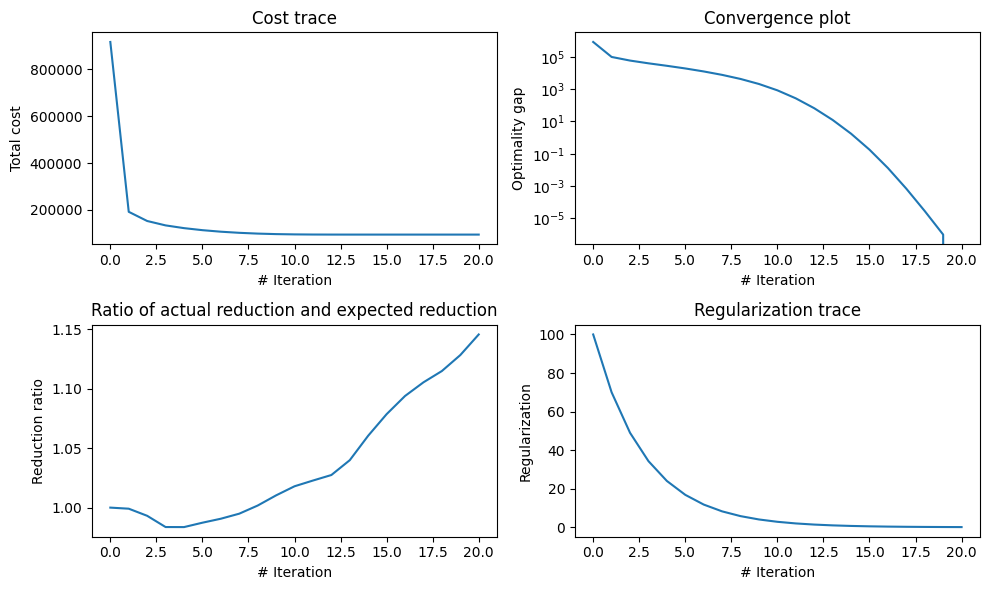

In [740]:
plt.subplots(figsize=(10,6))
# Plot results
plt.subplot(2, 2, 1)
plt.plot(cost_trace)
plt.xlabel('# Iteration')
plt.ylabel('Total cost')
plt.title('Cost trace')

plt.subplot(2, 2, 2)
delta_opt = (np.array(cost_trace) - cost_trace[-1])
plt.plot(delta_opt)
plt.yscale('log')
plt.xlabel('# Iteration')
plt.ylabel('Optimality gap')
plt.title('Convergence plot')

plt.subplot(2, 2, 3)
plt.plot(redu_ratio_trace)
plt.title('Ratio of actual reduction and expected reduction')
plt.ylabel('Reduction ratio')
plt.xlabel('# Iteration')

plt.subplot(2, 2, 4)
plt.plot(regu_trace)
plt.title('Regularization trace')
plt.ylabel('Regularization')
plt.xlabel('# Iteration')
plt.tight_layout()

### Convergence Analysis
You can find some plots of the convergence traces captured throughout the iLQR solve process above. The convergence plot indicates that we have achieved superlinear convergence. In fact, iLQR achieves nearly second order convergence. In the case of linear convergence (e.g. gradient descent), the [graph would show a line](https://en.wikipedia.org/wiki/Rate_of_convergence). While the integrated regularization improves robustness it damps convergence in the early iteration steps. 

In the ideal case, the expected reduction and the actual reduction should be the same, i.e. the reduction ratio remains around 1. If that is the case, the quadratic approximation of costs and linear approximation of the dynamics are very accurate. If the ratio becomes significantly lower than 1, the regularization needs to be increased and thus the stepsize reduced.